In [48]:
from utils import *

# Data preprocessing and loading for fast training

## Load source data

In [52]:
CONST_COLUMNS = [
    "Stellensubart_1",
    "Stellensubart_2",
    "Stellensubart_3",
    "Stellensubart_4",
    *[f"T{i}" for i in range(1, 35)],
    "Einwohner",
    "Preis",
    "Beleuchtet",
    "Laenge",
    "Breite",
    "Eigenfläche",
    "PPSVACWert",
    "Qid",
    "GJ",
]
data = pd.read_pickle("data/df_gesamt_15_08_prepocessed_einworner_added.pkl")
target_year_having_qid = data[data.GJ == 2023].Qid
cleaned_data = data[data.Qid.isin(target_year_having_qid)]
cleaned_data = cleaned_data.sort_values(by=["Qid", "GJ"]).set_index("Qid", drop=False)
cleaned_data = cleaned_data.loc[:, CONST_COLUMNS]

## Load distance data

In [53]:
distance_2018 = pd.read_csv("./data/distances/distances_2018.csv").set_index("Qid1")
distance_2019 = pd.read_csv("./data/distances/distances_2019.csv").set_index("Qid1")
distance_2020 = pd.read_csv("./data/distances/distances_2020.csv").set_index("Qid1")
distance_2021 = pd.read_csv("./data/distances/distances_2021.csv").set_index("Qid1")
distance_2022 = pd.read_csv("./data/distances/distances_2022.csv").set_index("Qid1")

## Normalize cols

In [55]:
# cleaned_data.Preis = (
#     cleaned_data.Preis - cleaned_data.Preis.mean()
# ) / cleaned_data.Preis.std()

cleaned_data.Laenge = (cleaned_data.Laenge - (-180.0)) / (2 * 180.0)
cleaned_data.Breite = (cleaned_data.Breite - (-90.0)) / (2 * 90.0)

cleaned_data.PPSVACWert = (
    cleaned_data.PPSVACWert - cleaned_data.PPSVACWert.mean()
) / cleaned_data.PPSVACWert.std()

cleaned_data.Preis = (
    cleaned_data.Preis - cleaned_data.Preis.mean()
) / cleaned_data.Preis.std()

cleaned_data.Einwohner = (
    cleaned_data.Einwohner - cleaned_data.Einwohner.mean()
) / cleaned_data.Einwohner.std()

In [56]:
cleaned_data.loc[:, "T1":"T22"] = cleaned_data.loc[:, "T1":"T22"].replace(-1, 0)

## Split data into years

In [57]:
data_2018 = cleaned_data[cleaned_data.GJ == 2018].drop(columns=["Qid", "GJ"]).copy()
data_2019 = cleaned_data[cleaned_data.GJ == 2019].drop(columns=["Qid", "GJ"]).copy()
data_2020 = cleaned_data[cleaned_data.GJ == 2020].drop(columns=["Qid", "GJ"]).copy()
data_2021 = cleaned_data[cleaned_data.GJ == 2021].drop(columns=["Qid", "GJ"]).copy()
data_2022 = cleaned_data[cleaned_data.GJ == 2022].drop(columns=["Qid", "GJ"]).copy()
data_2023 = cleaned_data[cleaned_data.GJ == 2023].drop(columns=["Qid", "GJ"]).copy()

## Calculate label

In [63]:
treshold = data_2023.loc[:, "T1":"T22"].mean(axis=1).quantile(0.5)

In [65]:
data_2023["target"] = (data_2023.loc[:, "T1":"T22"].mean(axis=1) > 0.5).astype(float)

## Train / Validation split

In [67]:
all_valid_qids = cleaned_data.Qid.unique()
qid_train, qid_val = train_test_split(
    all_valid_qids, test_size=0.1, random_state=2908
)

## Data Loading

In [72]:
all_year_data = [
    data_2018,
    data_2019,
    data_2020,
    data_2021,
    data_2022,
    data_2023,
]

all_year_distances = [
    distance_2018,
    distance_2019,
    distance_2020,
    distance_2021,
    distance_2022,
]

In [73]:
def preprocess_data(qids, all_year_data, all_year_distances, data_2023):
    MAX_NEIGH = 10
    columns_to_drop = ["PPSVACWert", *[f"T{i}" for i in range(1, 35)], "target"]

    X, x, y = [], [], []

    for idx, qid in enumerate(tqdm(qids)):
        neighbours_features = []

        for year_data, year_distances in zip(all_year_data, all_year_distances):
            current_distances = year_distances[year_distances.index == qid]

            if current_distances.shape[0] != 0:
                current_year_neighbours = current_distances[
                    current_distances.Qid2 != qid
                ]
                current_year_neighbours_data = torch.from_numpy(
                    year_data.loc[current_year_neighbours.Qid2].values
                )
                current_year_neighbours_data_padded = pad(
                    current_year_neighbours_data,
                    (0, 0, 0, MAX_NEIGH - current_year_neighbours_data.shape[0]),
                    "constant",
                    0,
                )

                current_year_self_data = torch.from_numpy(year_data.loc[qid].values)

                if (current_year_self_data.ndim == 2) and (
                    current_year_self_data.shape[0] > 1
                ):
                    current_year_self_data = current_year_self_data[0]

                current_year_data_point = torch.cat(
                    [current_year_self_data[None], current_year_neighbours_data_padded],
                    dim=0,
                )

            else:
                current_year_data_point = torch.zeros(MAX_NEIGH + 1, year_data.shape[1])

            neighbours_features.append(current_year_data_point)

        self_data_2023 = torch.from_numpy(
            data_2023.loc[qid].drop(labels=columns_to_drop).values
        )
        neighbours_features = torch.stack(neighbours_features, dim=0)
        label = torch.tensor([data_2023.loc[qid, "target"]])

        X.append(neighbours_features)
        x.append(self_data_2023)
        y.append(label)

    X = torch.stack(X, dim=0)
    x = torch.stack(x, dim=0)
    y = torch.stack(y, dim=0)

    return X, x, y

In [86]:
class CustomDataset(Dataset):
    def __init__(
        self,
        path_X,
        path_x,
        path_y,
    ):
        self.data_X = torch.load(path_X).to(dtype=torch.float32)
        self.data_x = torch.load(path_x).to(dtype=torch.float32)
        self.data_y = torch.load(path_y).to(dtype=torch.float32)


    def __getitem__(self, index):
        X, x, y = (
            self.data_X[index].clone(),
            self.data_x[index].clone(),
            self.data_y[index].clone(),
        )

        return X, x, y

    def __len__(self):
        return len(self.data_X)

In [339]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
        )
                    
        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size + 10, hidden_size // 2),
            LReLU(),
            nn.Dropout1d(0.1),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            LReLU(),
            nn.Dropout1d(0.1),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            LReLU(),
            nn.Dropout1d(0.1),
            nn.Linear(hidden_size // 8, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x, x_target):
        out = self.fc_1(x)
        out = out[..., 0]
        out, _ = self.lstm(out)
        out = out[:, -1, ...]
        out = torch.cat([out, x_target], dim=-1)
        out = self.fc_2(out)

        return out

In [416]:
class LReLU(nn.Module):
    def __init__(self, slope = 1):
        super().__init__()
        self.positive_slope = torch.nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
            
        return F.relu(x)**2

### Train data

In [ ]:
X_train, x_train, y_train = preprocess_data(
    qid_train, all_year_data, all_year_distances, data_2023
)

torch.save(X_train.permute(0, 1, 3, 2), "./data/proof_of_concept/X_train_lstm_year_price_29.pt")
torch.save(x_train, "./data/proof_of_concept/x_train_lstm_year_price_29.pt")
torch.save(y_train, "./data/proof_of_concept/y_train_lstm_year_price_29.pt")

### Validation data

In [78]:
X_val, x_val, y_val = preprocess_data(
    qid_val, all_year_data, all_year_distances, data_2023
)

torch.save(X_val.permute(0, 1, 3, 2), "./data/proof_of_concept/X_val_lstm_year_price_29.pt")
torch.save(x_val, "./data/proof_of_concept/x_val_lstm_year_price_29.pt")
torch.save(y_val, "./data/proof_of_concept/y_val_lstm_year_price_29.pt")

100%|████████████████████████████████████████████████████████████████████████████| 13590/13590 [00:51<00:00, 265.93it/s]


### Test data

In [417]:
# X_test, x_test, y_test = preprocess_data(
#     [9860, 9673, 9855, 9333], all_year_data, all_year_distances, data_2023
# )

# torch.save(X_test, "./data/proof_of_concept/X_test_lstm_year_price.pt")
# torch.save(x_test, "./data/proof_of_concept/x_test_lstm_year_price.pt")
# torch.save(y_test, "./data/proof_of_concept/y_test_lstm_year_price.pt")

# Preparation for training

In [418]:
BATCH_SIZE = 64
LEARNING_RATE = 0.003
WEIGHT_DECAY = 1e-5
EPS = torch.tensor([1e-8]).to(DEVICE)

In [419]:
def loss_fn(labels, preds):
    global EPS
    loss = -torch.mean(torch.log(torch.max(torch.gather(preds, dim=1, index=labels.to(int)), EPS)))
    return loss

In [420]:
model = LSTMModel(45, 512, 5, 1).to(DEVICE)
criterion = loss_fn

In [421]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [422]:
# def balacing(data):
    
#     neg_id = torch.where(data.data_y == 0)[0]
#     pos_id = torch.where(data.data_y == 1)[0]
    
#     k = neg_id.shape[0] // pos_id.shape[0]
    
#     data.data_y = torch.cat([data.data_y[pos_id].repeat(k, 1), data.data_y[neg_id]])
#     data.data_X = torch.cat([data.data_X[pos_id].repeat(k, 1, 1, 1), data.data_X[neg_id]])
#     data.data_x = torch.cat([data.data_x[pos_id].repeat(k, 1), data.data_x[neg_id]])    

In [423]:
# train_dataset = CustomDataset(
#     "./data/proof_of_concept/X_train_lstm_year_price_29.pt",
#     "./data/proof_of_concept/x_train_lstm_year_price_29.pt",
#     "./data/proof_of_concept/y_train_lstm_year_price_29.pt",
# )

val_dataset = CustomDataset(
    "./data/proof_of_concept/X_val_lstm_year_price_29.pt",
    "./data/proof_of_concept/x_val_lstm_year_price_29.pt",
    "./data/proof_of_concept/y_val_lstm_year_price_29.pt",
)

# train_dataloader = DataLoader(
#     train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
# )
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

# print(f"Total training instances:\t{train_dataset.data_X.shape[0]}")
# print(f"Total validation instances:\t{val_dataset.data_X.shape[0]}")

In [424]:
# data_X, data_x, data_y = train_dataset.data_X, train_dataset.data_x, train_dataset.data_y

# neg_mask = (data_y == 0)[:, 0]
# pos_mask = (data_y == 1)[:, 0]

# data_X_negative = torch.split(data_X[neg_mask], pos_mask.sum())
# data_x_negative = torch.split(data_x[neg_mask], pos_mask.sum())
# data_y_negative = torch.split(data_y[neg_mask], pos_mask.sum())

# for j, (data_X_neg, data_x_neg, data_y_neg) in enumerate(zip(data_X_negative, data_x_negative, data_y_negative)):
    
#     torch.save(torch.cat([data_X_neg, data_X[pos_mask]], dim=0), f"./data/balanced_training/data_X_{j}.pt")
#     torch.save(torch.cat([data_x_neg, data_x[pos_mask]], dim=0), f"./data/balanced_training/data_x_{j}.pt")
#     torch.save(torch.cat([data_y_neg, data_y[pos_mask]], dim=0), f"./data/balanced_training/data_y_{j}.pt")    

# Training

In [425]:
num_epochs = 100
history = []
val_min_loss = float("+inf")

model_name = ""

while model_name == "":
    model_name = input("Input proper model name:\t")

Input proper model name:	test


In [426]:
train_dataset_index = -1
change_every = 5

for epoch in range(num_epochs):
    
    if epoch % change_every == 0:
        train_dataset_index = (train_dataset_index + 1) % 6
    
        train_dataset = CustomDataset(
        f"./data/balanced_training/data_X_{train_dataset_index}.pt",
        f"./data/balanced_training/data_x_{train_dataset_index}.pt",
        f"./data/balanced_training/data_y_{train_dataset_index}.pt",
        )
        train_dataloader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
        )
    
    
    mean_train_loss = train(model, train_dataloader, criterion, optimizer)
    mean_val_loss = validate(model, val_dataloader, criterion)

    history.append([mean_train_loss, mean_val_loss])
    print(
        f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
        f"\nBest Val loss: {round(val_min_loss, 4)}"
    )

    if mean_val_loss < val_min_loss:
        val_min_loss = mean_val_loss
        print("Saving best model....")
        torch.save(model.state_dict(), f"./models/{model_name}_best.pt")

100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 550.57it/s]


Epoch [1/100]
Train Loss: 0.6408
Val Loss: 0.5862
Best Val loss: inf
Saving best model....


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 550.32it/s]


Epoch [2/100]
Train Loss: 0.6082
Val Loss: 0.5438
Best Val loss: 0.5862
Saving best model....


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 550.50it/s]


Epoch [3/100]
Train Loss: 0.6027
Val Loss: 0.5735
Best Val loss: 0.5438


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.94it/s]


Epoch [4/100]
Train Loss: 0.5964
Val Loss: 0.6365
Best Val loss: 0.5438


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.22it/s]


Epoch [5/100]
Train Loss: 0.5931
Val Loss: 0.4888
Best Val loss: 0.5438
Saving best model....


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.83it/s]


Epoch [6/100]
Train Loss: 0.5916
Val Loss: 0.5566
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.77it/s]


Epoch [7/100]
Train Loss: 0.5929
Val Loss: 0.5249
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.64it/s]


Epoch [8/100]
Train Loss: 0.5922
Val Loss: 0.5574
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.19it/s]


Epoch [9/100]
Train Loss: 0.6193
Val Loss: 0.583
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.48it/s]


Epoch [10/100]
Train Loss: 0.5892
Val Loss: 0.5111
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.87it/s]


Epoch [11/100]
Train Loss: 0.5869
Val Loss: 0.5317
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.73it/s]


Epoch [12/100]
Train Loss: 0.5865
Val Loss: 0.495
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.44it/s]


Epoch [13/100]
Train Loss: 0.5877
Val Loss: 0.5182
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.52it/s]


Epoch [14/100]
Train Loss: 0.5884
Val Loss: 0.5563
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.49it/s]


Epoch [15/100]
Train Loss: 0.5878
Val Loss: 0.5047
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.18it/s]


Epoch [16/100]
Train Loss: 0.5875
Val Loss: 0.5163
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.50it/s]


Epoch [17/100]
Train Loss: 0.594
Val Loss: 0.5513
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.58it/s]


Epoch [18/100]
Train Loss: 0.5899
Val Loss: 0.5913
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.65it/s]


Epoch [19/100]
Train Loss: 0.5883
Val Loss: 0.5857
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.30it/s]


Epoch [20/100]
Train Loss: 0.588
Val Loss: 0.5622
Best Val loss: 0.4888


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.85it/s]


Epoch [21/100]
Train Loss: 0.5892
Val Loss: 0.4773
Best Val loss: 0.4888
Saving best model....


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.90it/s]


Epoch [22/100]
Train Loss: 0.5877
Val Loss: 0.5413
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.28it/s]


Epoch [23/100]
Train Loss: 0.5884
Val Loss: 0.5196
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.41it/s]


Epoch [24/100]
Train Loss: 0.593
Val Loss: 0.5098
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.89it/s]


Epoch [25/100]
Train Loss: 0.5898
Val Loss: 0.5348
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.43it/s]


Epoch [26/100]
Train Loss: 0.5898
Val Loss: 0.6012
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.36it/s]


Epoch [27/100]
Train Loss: 0.5919
Val Loss: 0.5869
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.70it/s]


Epoch [28/100]
Train Loss: 0.5891
Val Loss: 0.6318
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.60it/s]


Epoch [29/100]
Train Loss: 0.5951
Val Loss: 0.5685
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 541.31it/s]


Epoch [30/100]
Train Loss: 0.5886
Val Loss: 0.5316
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.82it/s]


Epoch [31/100]
Train Loss: 0.5917
Val Loss: 0.5082
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 540.23it/s]


Epoch [32/100]
Train Loss: 0.5926
Val Loss: 0.543
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 540.12it/s]


Epoch [33/100]
Train Loss: 0.597
Val Loss: 0.554
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.82it/s]


Epoch [34/100]
Train Loss: 0.6019
Val Loss: 0.5635
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.90it/s]


Epoch [35/100]
Train Loss: 0.6091
Val Loss: 0.5185
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.62it/s]


Epoch [36/100]
Train Loss: 0.6027
Val Loss: 0.5403
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.80it/s]


Epoch [37/100]
Train Loss: 0.6008
Val Loss: 0.5635
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 540.25it/s]


Epoch [38/100]
Train Loss: 0.6044
Val Loss: 0.5603
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.65it/s]


Epoch [39/100]
Train Loss: 0.6012
Val Loss: 0.5161
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 540.20it/s]


Epoch [40/100]
Train Loss: 0.604
Val Loss: 0.5783
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.86it/s]


Epoch [41/100]
Train Loss: 0.6233
Val Loss: 0.6137
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.55it/s]


Epoch [42/100]
Train Loss: 1.1297
Val Loss: 0.5966
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.52it/s]


Epoch [43/100]
Train Loss: 0.621
Val Loss: 0.5738
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.98it/s]


Epoch [44/100]
Train Loss: 0.6194
Val Loss: 0.6818
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 540.58it/s]


Epoch [45/100]
Train Loss: 0.6177
Val Loss: 0.6214
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.83it/s]


Epoch [46/100]
Train Loss: 0.6166
Val Loss: 0.5958
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.29it/s]


Epoch [47/100]
Train Loss: 0.616
Val Loss: 0.5771
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.56it/s]


Epoch [48/100]
Train Loss: 0.62
Val Loss: 0.5915
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.68it/s]


Epoch [49/100]
Train Loss: 0.6191
Val Loss: 0.5585
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.60it/s]


Epoch [50/100]
Train Loss: 0.6189
Val Loss: 0.5941
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.67it/s]


Epoch [51/100]
Train Loss: 0.6217
Val Loss: 0.6073
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.81it/s]


Epoch [52/100]
Train Loss: 0.6173
Val Loss: 0.5447
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.88it/s]


Epoch [53/100]
Train Loss: 0.6151
Val Loss: 0.5319
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.76it/s]


Epoch [54/100]
Train Loss: 0.6174
Val Loss: 0.5997
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 538.63it/s]


Epoch [55/100]
Train Loss: 0.6168
Val Loss: 0.5939
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.54it/s]


Epoch [56/100]
Train Loss: 0.6147
Val Loss: 0.6068
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.37it/s]


Epoch [57/100]
Train Loss: 0.6147
Val Loss: 0.6347
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.60it/s]


Epoch [58/100]
Train Loss: 0.6126
Val Loss: 0.7247
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 540.32it/s]


Epoch [59/100]
Train Loss: 0.6144
Val Loss: 0.5737
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 540.00it/s]


Epoch [60/100]
Train Loss: 0.6138
Val Loss: 0.6083
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.22it/s]


Epoch [61/100]
Train Loss: 0.6151
Val Loss: 0.6103
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.82it/s]


Epoch [62/100]
Train Loss: 0.6156
Val Loss: 0.5517
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.53it/s]


Epoch [63/100]
Train Loss: 0.6408
Val Loss: 0.5089
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.53it/s]


Epoch [64/100]
Train Loss: 0.6126
Val Loss: 0.5834
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.61it/s]


Epoch [65/100]
Train Loss: 0.6066
Val Loss: 0.5787
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.29it/s]


Epoch [66/100]
Train Loss: 0.6052
Val Loss: 0.5195
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 539.60it/s]


Epoch [67/100]
Train Loss: 0.6054
Val Loss: 0.5491
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.66it/s]


Epoch [68/100]
Train Loss: 0.6047
Val Loss: 0.5674
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.26it/s]


Epoch [69/100]
Train Loss: 0.6025
Val Loss: 0.5484
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.31it/s]


Epoch [70/100]
Train Loss: 0.5995
Val Loss: 0.546
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.28it/s]


Epoch [71/100]
Train Loss: 0.6104
Val Loss: 0.558
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.06it/s]


Epoch [72/100]
Train Loss: 0.6033
Val Loss: 0.621
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.50it/s]


Epoch [73/100]
Train Loss: 0.5991
Val Loss: 0.5601
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.48it/s]


Epoch [74/100]
Train Loss: 0.599
Val Loss: 0.4998
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 545.23it/s]


Epoch [75/100]
Train Loss: 0.5998
Val Loss: 0.5549
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.42it/s]


Epoch [76/100]
Train Loss: 0.6018
Val Loss: 0.5382
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.56it/s]


Epoch [77/100]
Train Loss: 0.6003
Val Loss: 0.5269
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.69it/s]


Epoch [78/100]
Train Loss: 0.602
Val Loss: 0.5845
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.14it/s]


Epoch [79/100]
Train Loss: 0.6013
Val Loss: 0.5754
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.28it/s]


Epoch [80/100]
Train Loss: 0.6002
Val Loss: 0.5786
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.02it/s]


Epoch [81/100]
Train Loss: 0.5998
Val Loss: 0.5202
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.94it/s]


Epoch [82/100]
Train Loss: 0.6038
Val Loss: 0.6038
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.64it/s]


Epoch [83/100]
Train Loss: 0.603
Val Loss: 0.5694
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.84it/s]


Epoch [84/100]
Train Loss: 2.6642
Val Loss: 15.6482
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.62it/s]


Epoch [85/100]
Train Loss: 6.9604
Val Loss: 15.6482
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.70it/s]


Epoch [86/100]
Train Loss: 6.4698
Val Loss: 15.6482
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.80it/s]


Epoch [87/100]
Train Loss: 6.4385
Val Loss: 15.6482
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.67it/s]


Epoch [88/100]
Train Loss: 6.4698
Val Loss: 15.6482
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.84it/s]


Epoch [89/100]
Train Loss: 6.5408
Val Loss: 2.9061
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.00it/s]


Epoch [90/100]
Train Loss: 4.6275
Val Loss: 0.7255
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.39it/s]


Epoch [91/100]
Train Loss: 0.6939
Val Loss: 0.6555
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 547.67it/s]


Epoch [92/100]
Train Loss: 0.6938
Val Loss: 0.6947
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.23it/s]


Epoch [93/100]
Train Loss: 0.6935
Val Loss: 0.7167
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.24it/s]


Epoch [94/100]
Train Loss: 0.6934
Val Loss: 0.6768
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.11it/s]


Epoch [95/100]
Train Loss: 0.6934
Val Loss: 0.662
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.35it/s]


Epoch [96/100]
Train Loss: 2.3362
Val Loss: 15.6482
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.83it/s]


Epoch [97/100]
Train Loss: 6.8998
Val Loss: 15.6482
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 549.49it/s]


Epoch [98/100]
Train Loss: 6.9031
Val Loss: 15.6482
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.85it/s]


Epoch [99/100]
Train Loss: 5.0416
Val Loss: 0.5933
Best Val loss: 0.4773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 548.94it/s]

Epoch [100/100]
Train Loss: 0.6133
Val Loss: 0.6004
Best Val loss: 0.4773


In [427]:
torch.save(model.state_dict(), f"./models/{model_name}_last.pt")

In [428]:
best_weights = torch.load(f"./models/{model_name}_best.pt")
model.load_state_dict(best_weights);

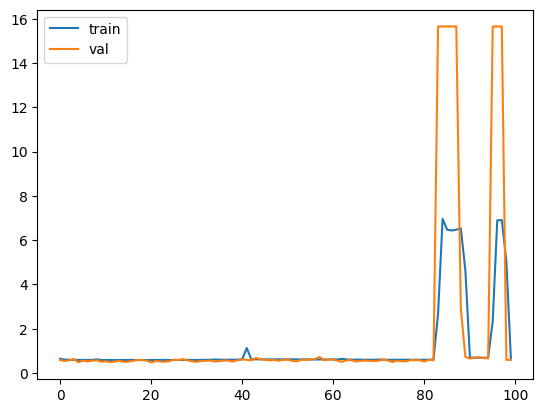

In [429]:
plt.plot(history)
plt.legend(["train", "val"])

# Evaluation

In [430]:
model.eval()

X_val = val_dataset.data_X#[:6000]
x_val = val_dataset.data_x#[:6000]
y_val = val_dataset.data_y#[:6000]

predictions = model(X_val.to(DEVICE), x_val.to(DEVICE)).detach().cpu().numpy().argmax(axis=-1)
ground_truth = y_val.numpy()[..., 0]

### ACC

In [431]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [432]:
accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions) 
recall = recall_score(ground_truth, predictions)
f1score = f1_score(ground_truth, predictions)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1score:.3f}")

Accuracy: 0.823
Precision: 0.425
Recall: 0.496
F1 score: 0.457


### Confusion Matrix

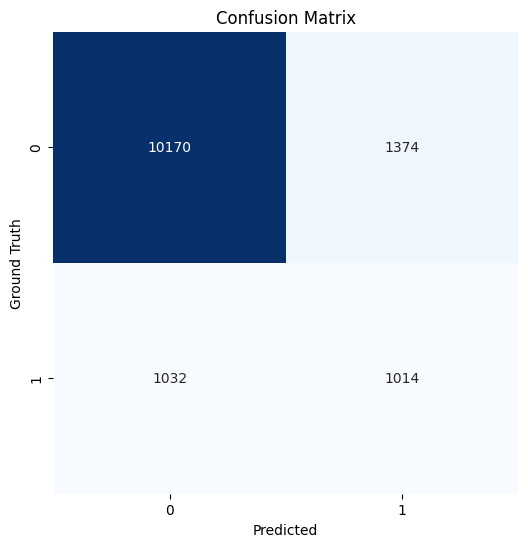

In [433]:
# Calculate confusion matrix
cm = confusion_matrix(ground_truth, predictions)

# Create a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()


### ROC Curve

In [239]:
# # Calculate ROC curve
# fpr, tpr, thresholds = roc_curve(ground_truth, predictions)

# # Calculate AUC score
# auc_score = roc_auc_score(ground_truth, predictions)

# # Create ROC curve plot
# plt.figure(figsize=(6, 6))
# plt.plot(fpr, tpr, color='b', label=f'AUC = {auc_score:.2f}')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()


## Kernel Density Estimation plot

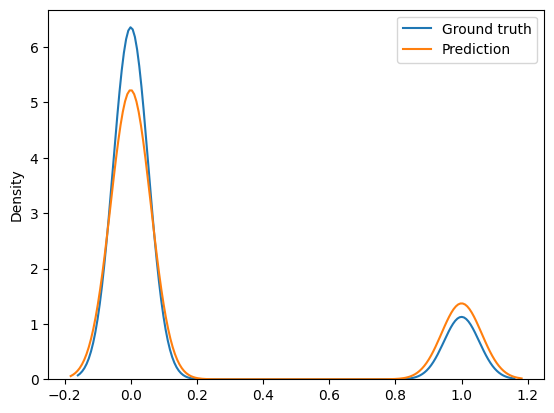

In [240]:
sns.kdeplot(ground_truth.flatten())
sns.kdeplot(predictions.flatten())
plt.legend(["Ground truth", "Prediction"])
plt.show()